1. UNZIP FILE

In [1]:
import zipfile
import os

# Ganti 'archive.zip' sesuai nama file yang kamu upload
zip_path = '/content/archive.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Isi folder setelah di-unzip:")
print(os.listdir(extract_path))


Isi folder setelah di-unzip:
['.config', 'Dog Emotion', 'archive.zip', 'sample_data']


2. membagi dataset menjadi train dan test

In [2]:
import os
import shutil
import random

# Path asli dataset
original_dataset_dir = '/content/Dog Emotion'

# Path tujuan hasil split
base_dir = '/content/dog_emotion_split'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Membuat folder train dan test
for directory in [train_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Rasio data latih vs data uji
split_ratio = 0.8

# Loop semua kategori: sad, happy, angry, relaxed
categories = os.listdir(original_dataset_dir)
for category in categories:
    category_path = os.path.join(original_dataset_dir, category)

    # Pastikan ini folder (bukan file)
    if not os.path.isdir(category_path):
        continue

    # Buat folder kategori di train dan test
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # Ambil semua nama file gambar
    images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))]
    random.shuffle(images)  # Acak gambar biar seimbang

    # Hitung jumlah data latih
    split_point = int(len(images) * split_ratio)
    train_images = images[:split_point]
    test_images = images[split_point:]

    # Salin gambar ke folder train dan test
    for img in train_images:
        src = os.path.join(category_path, img)
        dst = os.path.join(train_category_dir, img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(category_path, img)
        dst = os.path.join(test_category_dir, img)
        shutil.copy(src, dst)

print("✅ Dataset berhasil dibagi menjadi train dan test.")


✅ Dataset berhasil dibagi menjadi train dan test.


3. Exploratory Data Analysis (EDA)

Jumlah gambar di data latih:
{'relaxed': 800, 'sad': 800, 'happy': 800, 'angry': 800}

Jumlah gambar di data uji:
{'relaxed': 200, 'sad': 200, 'happy': 200, 'angry': 200}


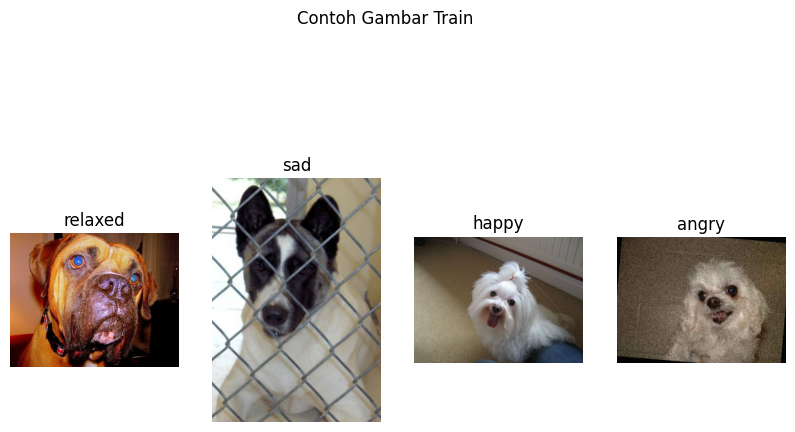

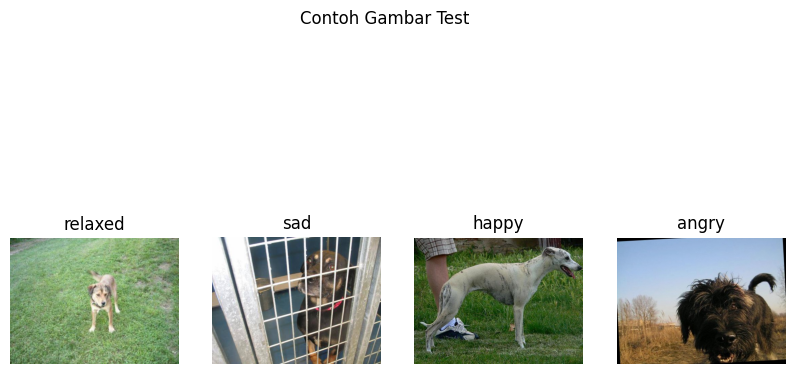

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Path ke data train dan test
train_dir = "/content/dog_emotion_split/train"
test_dir = "/content/dog_emotion_split/test"

# Fungsi untuk menghitung gambar di setiap kelas
def count_images(directory):
    counts = {}
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            counts[category] = len(os.listdir(category_path))
    return counts

# Hitung jumlah gambar
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Jumlah gambar di data latih:")
print(train_counts)
print("\nJumlah gambar di data uji:")
print(test_counts)

# Visualisasi beberapa gambar contoh dari setiap kelas
def show_sample_images(directory, title):
    plt.figure(figsize=(10, 6))
    categories = os.listdir(directory)
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        image_files = os.listdir(category_path)
        if image_files:
            img_path = os.path.join(category_path, image_files[0])
            img = Image.open(img_path)
            plt.subplot(1, len(categories), i+1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Tampilkan gambar contoh dari data latih dan uji
show_sample_images(train_dir, "Contoh Gambar Train")
show_sample_images(test_dir, "Contoh Gambar Test")

4. Exploratory Data Analysis (EDA)

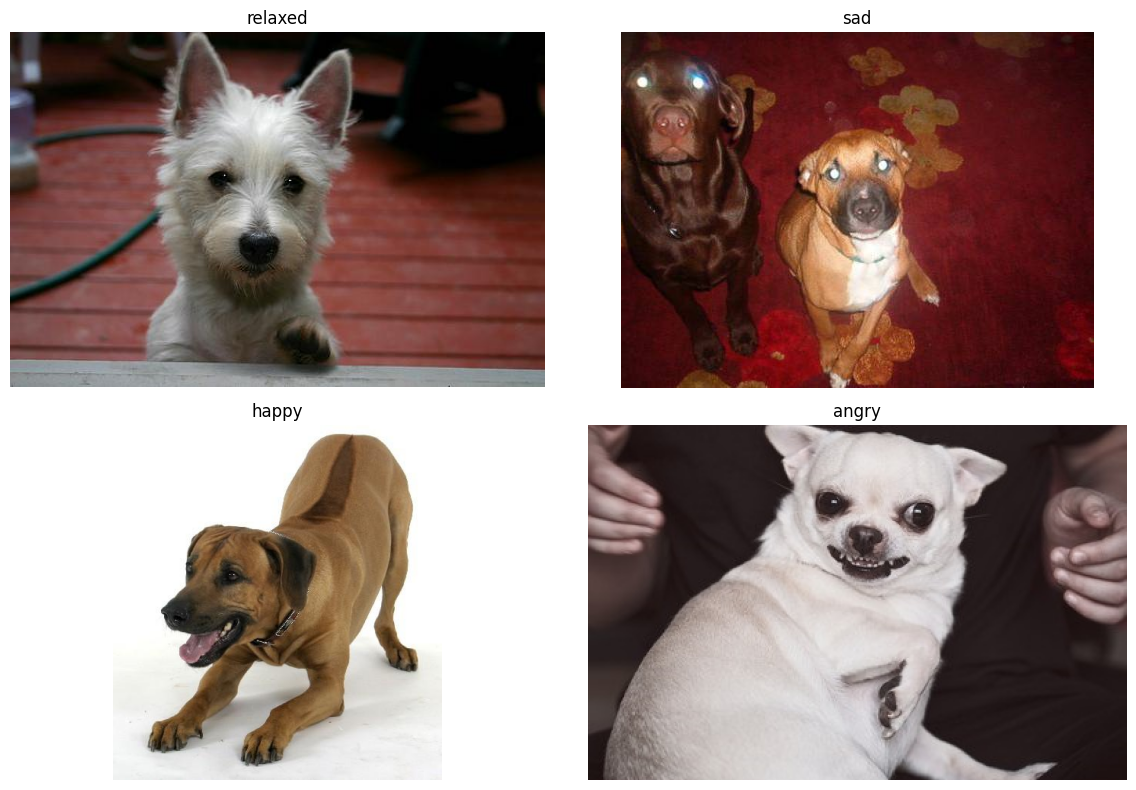

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Path ke folder data latih
train_dir = 'dog_emotion_split/train'
categories = os.listdir(train_dir)

# Tampilkan beberapa contoh gambar dari setiap kategori
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_file = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, image_file)

    img = mpimg.imread(image_path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

5. Feature Extraction & Preprocessing

In [16]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dog_emotion_split/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/dog_emotion_split/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)


Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


6. Pembangunan Model Transfer Learning (MobileNetV2)

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

 Memuat Base Model dan Bekukan Base Model

In [18]:
base_model = MobileNetV2(
    input_shape=(target_size[0], target_size[1], 3), # Sesuaikan dengan target_size
    include_top=False,
    weights='imagenet'
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [19]:
base_model.trainable = False

In [20]:

x = base_model.output
x = GlobalAveragePooling2D()(x) # Mengubah output 3D menjadi 1D
x = Dense(512, activation='relu')(x) # Lapisan Dense pertama
x = Dropout(0.5)(x) # Tetap gunakan Dropout untuk regularisasi
predictions = Dense(num_classes, activation='softmax')(x) # Lapisan output untuk 4 kelas Anda

model = Model(inputs=base_model.input, outputs=predictions)

7. Kompilasi Model

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

8. Pelatihan Model dengan Early Stopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import ModelCheckpoint

# --- Tambahkan definisi ModelCheckpoint di sini ---
model_checkpoint = ModelCheckpoint(
    filepath='best_dog_emotion_model.h5', # Nama file untuk menyimpan model
    monitor='val_loss',         # Pantau validation loss
    save_best_only=True,        # Hanya simpan model terbaik
    mode='min',                 # Mode 'min' karena kita ingin meminimalkan val_loss
    verbose=1                   # Tampilkan pesan ketika model disimpan
)
# --- Akhir penambahan ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Berhenti jika val_loss tidak membaik selama 10 epoch
    restore_best_weights=True # Kembalikan bobot model dari epoch terbaik
)

epochs_to_train = 50

print(f"\nMemulai pelatihan model dengan Transfer Learning ({epochs_to_train} epoch)...")
history = model.fit(
    train_generator,
    epochs=epochs_to_train,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

print("\nPelatihan selesai!")


Memulai pelatihan model dengan Transfer Learning (50 epoch)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.3097 - loss: 1.5672
Epoch 1: val_loss improved from inf to 1.11147, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - accuracy: 0.3103 - loss: 1.5657 - val_accuracy: 0.5312 - val_loss: 1.1115
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4902 - loss: 1.1673
Epoch 2: val_loss improved from 1.11147 to 0.99878, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.4904 - loss: 1.1670 - val_accuracy: 0.5863 - val_loss: 0.9988
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5480 - loss: 1.0525
Epoch 3: val_loss improved from 0.99878 to 0.94773, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.5481 - loss: 1.0523 - val_accuracy: 0.6075 - val_loss: 0.9477
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6086 - loss: 0.9599
Epoch 4: val_loss improved from 0.94773 to 0.91644, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 441ms/step - accuracy: 0.6085 - loss: 0.9602 - val_accuracy: 0.6187 - val_loss: 0.9164
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6219 - loss: 0.9405
Epoch 5: val_loss improved from 0.91644 to 0.88524, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.6219 - loss: 0.9403 - val_accuracy: 0.6275 - val_loss: 0.8852
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.6492 - loss: 0.8726
Epoch 6: val_loss improved from 0.88524 to 0.87363, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.6491 - loss: 0.8726 - val_accuracy: 0.6400 - val_loss: 0.8736
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6507 - loss: 0.8499
Epoch 7: val_loss improved from 0.87363 to 0.85527, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.6507 - loss: 0.8499 - val_accuracy: 0.6513 - val_loss: 0.8553
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6678 - loss: 0.8374
Epoch 8: val_loss improved from 0.85527 to 0.84980, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 445ms/step - accuracy: 0.6678 - loss: 0.8373 - val_accuracy: 0.6425 - val_loss: 0.8498
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6839 - loss: 0.7875
Epoch 9: val_loss improved from 0.84980 to 0.82597, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 421ms/step - accuracy: 0.6838 - loss: 0.7876 - val_accuracy: 0.6513 - val_loss: 0.8260
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6838 - loss: 0.7807
Epoch 10: val_loss improved from 0.82597 to 0.80788, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - accuracy: 0.6837 - loss: 0.7807 - val_accuracy: 0.6600 - val_loss: 0.8079
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6936 - loss: 0.7589
Epoch 11: val_loss improved from 0.80788 to 0.79568, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 438ms/step - accuracy: 0.6937 - loss: 0.7588 - val_accuracy: 0.6637 - val_loss: 0.7957
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7184 - loss: 0.6988
Epoch 12: val_loss improved from 0.79568 to 0.77672, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 422ms/step - accuracy: 0.7184 - loss: 0.6990 - val_accuracy: 0.6787 - val_loss: 0.7767
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7283 - loss: 0.7001
Epoch 13: val_loss did not improve from 0.77672
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.7283 - loss: 0.7002 - val_accuracy: 0.6725 - val_loss: 0.7787
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7440 - loss: 0.6818
Epoch 14: val_loss did not improve from 0.77672
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.7439 - loss: 0.6819 - val_accuracy: 0.6662 - val_loss: 0.7781
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7317 - loss: 0.6691
Epoch 15: val_loss improved from 0.77672 to 0.76342, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.7316 - loss: 0.6693 - val_accuracy: 0.6837 - val_loss: 0.7634
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7452 - loss: 0.6660
Epoch 16: val_loss did not improve from 0.76342
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.7452 - loss: 0.6660 - val_accuracy: 0.6812 - val_loss: 0.7645
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7436 - loss: 0.6457
Epoch 17: val_loss improved from 0.76342 to 0.75735, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step - accuracy: 0.7436 - loss: 0.6457 - val_accuracy: 0.6850 - val_loss: 0.7574
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7465 - loss: 0.6476
Epoch 18: val_loss did not improve from 0.75735
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 444ms/step - accuracy: 0.7465 - loss: 0.6476 - val_accuracy: 0.6850 - val_loss: 0.7615
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7581 - loss: 0.6284
Epoch 19: val_loss improved from 0.75735 to 0.74408, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.7580 - loss: 0.6285 - val_accuracy: 0.6800 - val_loss: 0.7441
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7620 - loss: 0.6058
Epoch 20: val_loss improved from 0.74408 to 0.74195, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.7620 - loss: 0.6058 - val_accuracy: 0.6888 - val_loss: 0.7419
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7857 - loss: 0.5930
Epoch 21: val_loss did not improve from 0.74195
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.7856 - loss: 0.5929 - val_accuracy: 0.6925 - val_loss: 0.7437
Epoch 22/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7856 - loss: 0.5679
Epoch 22: val_loss improved from 0.74195 to 0.73567, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 424ms/step - accuracy: 0.7857 - loss: 0.5680 - val_accuracy: 0.6963 - val_loss: 0.7357
Epoch 23/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7965 - loss: 0.5606
Epoch 23: val_loss improved from 0.73567 to 0.73347, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 440ms/step - accuracy: 0.7964 - loss: 0.5609 - val_accuracy: 0.7000 - val_loss: 0.7335
Epoch 24/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7923 - loss: 0.5399
Epoch 24: val_loss improved from 0.73347 to 0.72495, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.7923 - loss: 0.5400 - val_accuracy: 0.7013 - val_loss: 0.7249
Epoch 25/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8018 - loss: 0.5475
Epoch 25: val_loss did not improve from 0.72495
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - accuracy: 0.8017 - loss: 0.5475 - val_accuracy: 0.6850 - val_loss: 0.7257
Epoch 26/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7748 - loss: 0.5670
Epoch 26: val_loss did not improve from 0.72495
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.7750 - loss: 0.5667 - val_accuracy: 0.6963 - val_loss: 0.7305
Epoch 27/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8016 - loss: 0.5285
Epoch 27: val_loss improved from 0.72495 to 0.71932, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 438ms/step - accuracy: 0.8016 - loss: 0.5285 - val_accuracy: 0.6988 - val_loss: 0.7193
Epoch 28/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8169 - loss: 0.5146
Epoch 28: val_loss did not improve from 0.71932
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.8168 - loss: 0.5147 - val_accuracy: 0.6862 - val_loss: 0.7281
Epoch 29/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8028 - loss: 0.5240
Epoch 29: val_loss did not improve from 0.71932
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.8029 - loss: 0.5240 - val_accuracy: 0.6900 - val_loss: 0.7255
Epoch 30/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8120 - loss: 0.4920
Epoch 30: val_loss improved from 0.71932 to 0.71173, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.8121 - loss: 0.4920 - val_accuracy: 0.7000 - val_loss: 0.7117
Epoch 31/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8234 - loss: 0.4728
Epoch 31: val_loss did not improve from 0.71173
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 418ms/step - accuracy: 0.8233 - loss: 0.4730 - val_accuracy: 0.7025 - val_loss: 0.7183
Epoch 32/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8164 - loss: 0.4721
Epoch 32: val_loss did not improve from 0.71173
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.8164 - loss: 0.4723 - val_accuracy: 0.6913 - val_loss: 0.7228
Epoch 33/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8276 - loss: 0.4699
Epoch 33: val_loss did not improve from 0.71173
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.8276 - loss: 0.4698 - val_accuracy: 0.6963 - val_loss: 0.7232
Epoch 34/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8357 - loss: 0.4653
Epoch 34: val_loss d

100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.8449 - loss: 0.4253 - val_accuracy: 0.7125 - val_loss: 0.7088
Epoch 36/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8416 - loss: 0.4377
Epoch 36: val_loss did not improve from 0.70880
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - accuracy: 0.8416 - loss: 0.4377 - val_accuracy: 0.7125 - val_loss: 0.7119
Epoch 37/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8290 - loss: 0.4440
Epoch 37: val_loss improved from 0.70880 to 0.70119, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.8291 - loss: 0.4440 - val_accuracy: 0.7125 - val_loss: 0.7012
Epoch 38/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8444 - loss: 0.4312
Epoch 38: val_loss improved from 0.70119 to 0.69854, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.8444 - loss: 0.4311 - val_accuracy: 0.7113 - val_loss: 0.6985
Epoch 39/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8578 - loss: 0.4156
Epoch 39: val_loss did not improve from 0.69854
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.8577 - loss: 0.4157 - val_accuracy: 0.7200 - val_loss: 0.7060
Epoch 40/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8489 - loss: 0.4260
Epoch 40: val_loss did not improve from 0.69854
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 423ms/step - accuracy: 0.8489 - loss: 0.4260 - val_accuracy: 0.7237 - val_loss: 0.7054
Epoch 41/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8439 - loss: 0.4124
Epoch 41: val_loss improved from 0.69854 to 0.69462, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.8440 - loss: 0.4124 - val_accuracy: 0.7150 - val_loss: 0.6946
Epoch 42/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8555 - loss: 0.4052
Epoch 42: val_loss improved from 0.69462 to 0.68605, saving model to best_dog_emotion_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.8555 - loss: 0.4053 - val_accuracy: 0.7212 - val_loss: 0.6860
Epoch 43/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8619 - loss: 0.4004
Epoch 43: val_loss did not improve from 0.68605
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 425ms/step - accuracy: 0.8620 - loss: 0.4003 - val_accuracy: 0.7200 - val_loss: 0.7121
Epoch 44/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8651 - loss: 0.3765
Epoch 44: val_loss did not improve from 0.68605
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.8651 - loss: 0.3765 - val_accuracy: 0.7088 - val_loss: 0.7202
Epoch 45/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8621 - loss: 0.3879
Epoch 45: val_loss did not improve from 0.68605
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 432ms/step - accuracy: 0.8621 - loss: 0.3878 - val_accuracy: 0.7125 - val_loss: 0.7130
Epoch 46/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8703 - loss: 0.3675
Epoch 46: val_loss d

Langkah 9: Visualisasi hasil pelatihan model

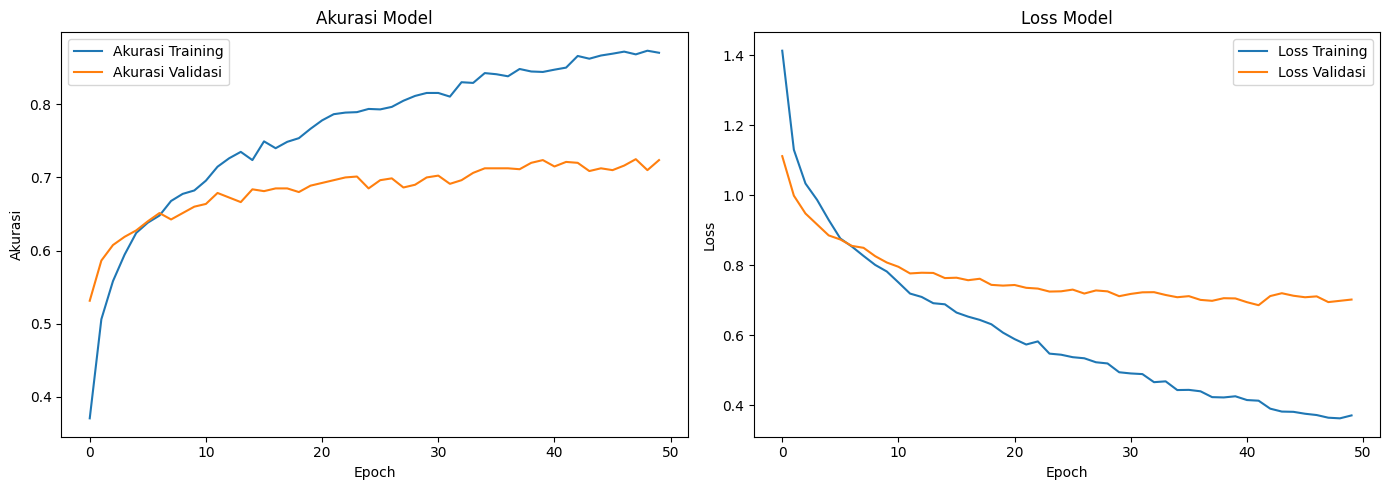

In [25]:
import matplotlib.pyplot as plt

# Plot akurasi pelatihan dan validasi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss pelatihan dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model 'best_dog_emotion_model.h5' loaded successfully.

Loading test data with target size (224, 224)...


Loading sad: 100%|██████████| 200/200 [00:00<00:00, 571.57it/s]


Using classes: ['angry', 'happy', 'relaxed', 'sad']

Predicting on test data...
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
Number of test samples: 800
Number of predicted samples: 800

--- Model Evaluation Metrics on Test Data ---
Test Loss: 0.6860
Test Accuracy: 0.7212

--- Confusion Matrix ---
[[142  28  19  11]
 [ 26 137  34   3]
 [ 15  31 132  22]
 [  9   9  16 166]]


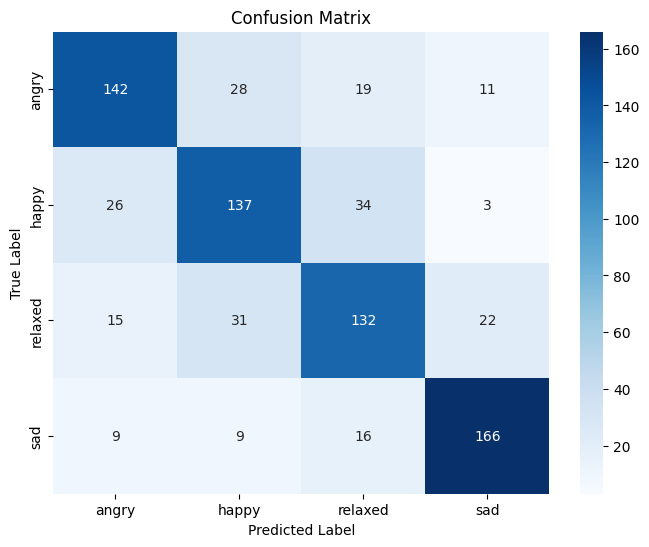


--- Classification Report ---
              precision    recall  f1-score   support

       angry       0.74      0.71      0.72       200
       happy       0.67      0.69      0.68       200
     relaxed       0.66      0.66      0.66       200
         sad       0.82      0.83      0.83       200

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800



In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img # Import necessary libraries
import os
from tqdm import tqdm


# Re-define the extract_features function here for clarity, or ensure it's run with the correct size
def extract_features(directory, image_size=(224, 224)): # Changed default size here
    features = []
    labels = []
    class_names = os.listdir(directory)
    class_names.sort()
    # Filter out non-directory entries like .ipynb_checkpoints or files
    class_names = [d for d in class_names if os.path.isdir(os.path.join(directory, d))]
    class_names.sort() # Sort again after filtering

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        # Check if it's actually a directory before listing files
        if os.path.isdir(class_dir):
            for img_name in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
                img_path = os.path.join(class_dir, img_name)
                # Add a check to ensure it's a file and has a common image extension
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    try:
                        img = load_img(img_path, target_size=image_size)
                        img = img_to_array(img)
                        img = img / 255.0
                        features.append(img)
                        labels.append(label)
                    except Exception as e:
                         print(f"Could not load or process image {img_path}: {e}")

    return np.array(features), np.array(labels), class_names


# --- 1. Load the trained model ---
# Assuming 'best_dog_emotion_transfer_model.h5' is the MobileNetV2 based model
try:
    model = load_model('best_dog_emotion_model.h5')
    print("Model 'best_dog_emotion_model.h5' loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_dog_emotion_model.h5' is in the current directory or provide the correct path.")
    # If the model can't be loaded, there's no point in continuing
    raise SystemExit("Failed to load model.")


# --- 2. Re-load the test data with the correct target_size ---
test_dir = '/content/dog_emotion_split/test'

# Extract features for the test data with the correct size (224, 224)
print("\nLoading test data with target size (224, 224)...")
x_test, y_test, class_names = extract_features(test_dir, image_size=(224, 224))

# Ensure x_test and y_test are available after extraction
if x_test.size == 0 or y_test.size == 0:
     print("No test data loaded. Please check the test directory path and its contents.")
     raise SystemExit("No test data available.")


# Get true labels directly from y_test
true_labels = y_test

# Get class labels from the class_names list
class_labels = class_names
print(f"Using classes: {class_labels}")


# --- 3. Get predictions for the test set ---
print("\nPredicting on test data...")
# Predict directly on the x_test numpy array (now 224x224)
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

print(f"Number of test samples: {len(true_labels)}")
print(f"Number of predicted samples: {len(predicted_labels)}")


# --- 4. Calculate and display metrics ---

print("\n--- Model Evaluation Metrics on Test Data ---")

# Evaluate model directly on the test data
# Ensure y_test is one-hot encoded if your model's loss is categorical_crossentropy
# If the model was compiled with 'sparse_categorical_crossentropy' and y_test is label encoded (integers), this is fine.
# Check the model compilation section. The model was compiled with 'categorical_crossentropy' and the generator used 'categorical',
# but extract_features returns label encoded integers.
# Let's one-hot encode y_test for evaluation and report.
from tensorflow.keras.utils import to_categorical
y_test_one_hot = to_categorical(y_test, num_classes=len(class_labels))


eval_result = model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Test Loss: {eval_result[0]:.4f}")
print(f"Test Accuracy: {eval_result[1]:.4f}")

# Confusion Matrix
print("\n--- Confusion Matrix ---")
# Use class_labels for xticklabels and yticklabels
cm = confusion_matrix(true_labels, predicted_labels) # Use true_labels (integer labels) for confusion matrix
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision, Recall, F1-score
print("\n--- Classification Report ---")
# Use target_names for the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels) # Use true_labels (integer labels) for report
print(report)

GUI APLIKASI

In [27]:
pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.8 MB/s eta 0:00:00


In [28]:
import anvil.server

anvil.server.connect("server_PV3JWNXEEX7KPTT73CVKEHYH-6HSMF3UGQPP67IY3")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Private link to branch master" as SERVER


In [31]:
from PIL import Image
import numpy as np
import io
import anvil.server

@anvil.server.callable
def klasifikasi_gambar(file):
    # Ambil dan konversi gambar
    image_bytes = file.get_bytes()
    img = Image.open(io.BytesIO(image_bytes)).convert('RGB').resize((128, 128))  # Sesuaikan ukuran

    # Preprocessing gambar
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 3)  # Sesuai input model

    # Prediksi
    hasil = model.predict(img_array)
    prediksi = np.argmax(hasil)

    # Opsional: beri label
    label = ['Angry', 'Happy', 'Relaxed', 'Sad']  # Ganti sesuai dataset kamu

    return f"Hasil Prediksi: {label[prediksi]} (Index: {prediksi})"


In [32]:
anvil.server.wait_forever()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


KeyboardInterrupt: 